# Inventory EDA

Inventory Data contains snapshot information about sku-level tons that were available in inventory at a specific date. This data pertains to Whitby mill (1302). 

One important consideration - the numbers in inventory could decrease by:
 1. Shipments
 2. Scrapping

Our assumption for this analysis is that most of the decreases will be derived from shipments. Thus the rate of change we assume to be equal to the rate of shipments for the items in analysis. 

**Given limited time for analysis we will focus on specific blocks**
- 4" ANG
- 5X3-1/2" ANG
- 5X3" ANG
- 4X3" ANG
- 3-1/2" ANG

Exploration areas:
- Distribution of inventory through time
- Is there cyclicality to inventory from month to month, or cycle to cycle
- Analysis on the cycle lenghts (avg. and std deviations)
- **Potential features that could serve as indicators for the prediction of production quantities**
    - rate of change in inventory increasing decreasing (especially in comparison to ATP available)
    - ...

#### Dependencies

In [57]:
#dependencies for EDA
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import ipywidgets as widgets
import plotly as py
import plotly.graph_objs as go

#### Read Dataframe

In [58]:
#%store -r inv_reduced
%store -r inv_reduced2

## Peaking at Data

In [59]:
#peak
inv_reduced2.head(-1)

,calendar_day,sku,material_description,material_type,strategy,ph,shape,block,size,steel_grade,length_text,tons
16,2016-01-03,106020238,"C 10X15.3# GGMULTI 20'00""",ZERT,MTS,LS-Mills-Mer-Mer-Strc A&C-Channels,SHAPE_C,"10"" CHN",10 X 15.3#,GGMULTI,"20'00""",200.736000
17,2016-01-03,106020239,"C 10X15.3# GGMULTI 40'00""",ZERT,MTS,LS-Mills-Mer-Mer-Strc A&C-Channels,SHAPE_C,"10"" CHN",10 X 15.3#,GGMULTI,"40'00""",352.206000
18,2016-01-03,106020242,"C 10X15.3# GGMULTI 50'00""",ZERT,MTS,LS-Mills-Mer-Mer-Strc A&C-Channels,SHAPE_C,"10"" CHN",10 X 15.3#,GGMULTI,"50'00""",99.450000
19,2016-01-03,106020243,"C 10X15.3# GGMULTI 60'00""",ZERT,MTS,LS-Mills-Mer-Mer-Strc A&C-Channels,SHAPE_C,"10"" CHN",10 X 15.3#,GGMULTI,"60'00""",26.622000
14,2016-01-03,106020214,"C 10X20# GGMULTI 20'00""",ZERT,MTS,LS-Mills-Mer-Mer-Strc A&C-Channels,SHAPE_C,"10"" CHN",10 X 20#,GGMULTI,"20'00""",38.400000
...,...,...,...,...,...,...,...,...,...,...,...,...
779016,2020-03-24,106019495,"L 8X8X1/2 GGMULTI 40'00""",ZERT,MTS,LS-Mills-Mer-Mer-Strc A&C-Angles,SHAPE_L,"8"" ANG",8X8X1/2,GGMULTI,"40'00""",19.007999
779017,2020-03-24,106019496,"L 8X8X3/4 GGMULTI 40'00""",ZERT,MTS,LS-Mills-Mer-Mer-Strc A&C-Angles,SHAPE_L,"8"" ANG",8X8X3/4,GGMULTI,"40'00""",42.012001
779354,2020-03-24,106029360,"L 8X8X5/8 GGMULTI 40'00""",ZERT,MTS,LS-Mills-Mer-Mer-Strc A&C-Angles,SHAPE_L,"8"" ANG",8X8X5/8,GGMULTI,"40'00""",11.772000
779018,2020-03-24,106019507,"MC 10X8.4# GGMULTI 20'00""",ZERT,MTS,LS-Mills-Mer-Mer-Strc A&C-MC Channels,SHAPE_MC,MC10X8.4,10 X 8.4#,GGMULTI,"20'00""",8.316000


In [60]:
#counts and dtypes
inv_reduced2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 774593 entries, 16 to 779020
Data columns (total 12 columns):
calendar_day            774593 non-null datetime64[ns]
sku                     774593 non-null object
material_description    774593 non-null object
material_type           774593 non-null object
strategy                767339 non-null category
ph                      774593 non-null object
shape                   771786 non-null object
block                   769246 non-null object
size                    771786 non-null object
steel_grade             771786 non-null object
length_text             769268 non-null object
tons                    774593 non-null float64
dtypes: category(1), datetime64[ns](1), float64(1), object(9)
memory usage: 71.7+ MB


In [61]:
#creating dataframe for analysis of null blocks in inventory
null_blocks = inv_reduced2[inv_reduced2["block"].isna()]

In [62]:
#looking to see offenders in Angle shapes (L_SHAPE)
null_blocks[null_blocks["shape"]=="SHAPE_L"]["size"].value_counts()

2X1 1/2X3/16    26
Name: size, dtype: int64

No offenders apparent in 4" ANG block:
- 4 X 4 X .344 UNB
- 4 X 4 X 1/2
- 4 X 4 X 1/4
- 4 X 4 X 3/4
- 4 X 4 X 3/8
- 4 X 4 X 5/16
- 4 X 4 X 7/16
- 4 X 4 X 9/16
- 4 X 4 X 5/8

## Distribution of Inventory through Time

### 4" ANG Analysis (to be used for replication)

In [63]:
#dataframe for (variable) block analysis
block_df = inv_reduced2[inv_reduced2["block"]=='4" ANG']

In [64]:
#number of skus in this block
block_df["sku"].nunique()

110

In [65]:
#description of block
block_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36378 entries, 126 to 779178
Data columns (total 12 columns):
calendar_day            36378 non-null datetime64[ns]
sku                     36378 non-null object
material_description    36378 non-null object
material_type           36378 non-null object
strategy                35571 non-null category
ph                      36378 non-null object
shape                   36378 non-null object
block                   36378 non-null object
size                    36378 non-null object
steel_grade             36378 non-null object
length_text             36378 non-null object
tons                    36378 non-null float64
dtypes: category(1), datetime64[ns](1), float64(1), object(9)
memory usage: 3.4+ MB


In [66]:
#quick description of 4" ANG inventory tons and ATP
block_df.describe()

,tons
count,36378.000000
mean,60.348227
std,138.361264
min,-0.002000
25%,0.001000
50%,4.900000
75%,52.910000
max,1859.219971


In [67]:
#Creating new columns to separate year, month and week
block_df = block_df.set_index("calendar_day")
block_df["year"] = block_df.index.year
block_df["month"] = block_df.index.month
block_df["week"] = block_df.index.week
block_df["day"] = block_df.index.dayofyear
block_df = block_df.reset_index()

In [68]:
block_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36378 entries, 0 to 36377
Data columns (total 16 columns):
calendar_day            36378 non-null datetime64[ns]
sku                     36378 non-null object
material_description    36378 non-null object
material_type           36378 non-null object
strategy                35571 non-null category
ph                      36378 non-null object
shape                   36378 non-null object
block                   36378 non-null object
size                    36378 non-null object
steel_grade             36378 non-null object
length_text             36378 non-null object
tons                    36378 non-null float64
year                    36378 non-null int64
month                   36378 non-null int64
week                    36378 non-null int64
day                     36378 non-null int64
dtypes: category(1), datetime64[ns](1), float64(1), int64(4), object(9)
memory usage: 4.2+ MB


In [69]:
block_df.columns

Index(['calendar_day', 'sku', 'material_description', 'material_type',
       'strategy', 'ph', 'shape', 'block', 'size', 'steel_grade',
       'length_text', 'tons', 'year', 'month', 'week', 'day'],
      dtype='object')

In [70]:
#Rearranging columns order
cols = list(block_df.columns.values)
cols = ['calendar_day', 'year', 'month', 'week', 'day', 'sku', 'material_description', 'material_type',
       'strategy', 'ph', 'shape', 'block', 'size', 'steel_grade',
       'length_text', 'tons']
block_df =block_df[cols]

In [71]:
block_df[block_df["year"]==2019]["day"].value_counts()

219    50
209    50
224    50
216    50
220    50
       ..
197    33
99     32
97     32
98     32
195    13
Name: day, Length: 272, dtype: int64

In [72]:
#distribution of inventory snapshots through years 
block_df["year"].value_counts()

2019    10745
2018    10280
2017     8180
2016     4822
2020     2351
Name: year, dtype: int64

In [73]:
#distribution of inventory snapshots by size
block_df["size"].value_counts()

4X4X5/16    10151
4X4X3/8      7597
4X4X1/4      5993
4X4X1/2      4393
4X4X3/4      2980
4X4X9/16     2809
4X4X.344     1438
4X4X5/8       925
4X4X7/16       92
Name: size, dtype: int64

Tons on Inventory

Text(0, 0.5, 'Tons')

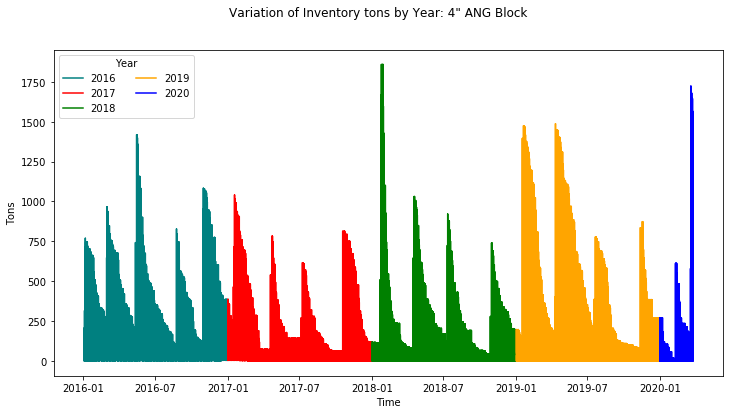

In [75]:
#creating df for each year
year_2016 = block_df[block_df.year == 2016]
year_2017 = block_df[block_df.year == 2017]
year_2018 = block_df[block_df.year == 2018]
year_2019 = block_df[block_df.year == 2019]
year_2020 = block_df[block_df.year == 2020]

#Create figure and plots
fig_dims = (12,6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Variation of Inventory tons by Year: 4" ANG Block')

ax.plot(year_2016.calendar_day, year_2016["tons"], label=2016, color ='teal')
ax.plot(year_2017.calendar_day, year_2017["tons"], label=2017, color ='r')
ax.plot(year_2018.calendar_day, year_2018["tons"], label=2018, color ='g')
ax.plot(year_2019.calendar_day, year_2019["tons"], label=2019, color ='orange')
ax.plot(year_2020.calendar_day, year_2020["tons"], label=2020, color ='b')

#Create legend & axis names
plt.legend(loc="best", title="Year", ncol=2)
ax.set_xlabel("Time")
ax.set_ylabel("Tons")

ATP for this Block

In [77]:
# #BLOCKED OUT TO TEST NEW INVENTORY
# #Create figure and plots
# fig_dims = (12,6)
# fig, ax = plt.subplots(figsize=fig_dims)
# fig.suptitle('Variation of ATP tons by Year: 4" ANG Block')

# #ax.plot(year_2017.calendar_day, year_2017["atp"], label=2017, color ='r')
# ax.plot(year_2018.calendar_day, year_2018["atp"], label=2018, color ='g')
# ax.plot(year_2019.calendar_day, year_2019["atp"], label=2019, color ='orange')
# ax.plot(year_2020.calendar_day, year_2020["atp"], label=2020, color='b')

# #Create legend & axis names
# plt.legend(loc="best", title="Year", ncol=2)
# ax.set_xlabel("Time")
# ax.set_ylabel("APT(in tons)")

In [39]:
##Checkout ipywidgets? - https://plotly.com/python/widget-app/   &   https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6
## If not continue exploring ways to plot simulatenously ATP

### Inventory & ATP Analysis

In [76]:
#Create Dropdown for blocks & sizes
blocks = widgets.Dropdown(options=['4" ANG','5 X 3-1/2" ANG','5 X 3" ANG','4 X 3" ANG', '3-1/2" ANG'])
sizes = widgets.Dropdown(options=list(inv_reduced2[inv_reduced2.block==blocks.value]["size"].value_counts().index))

#DATEPICKER IS NOT WORKING
start = widgets.DatePicker(description="Start Date", value=pd.to_datetime('2019-01-01'))
end = widgets.DatePicker(description="End Date", value=pd.to_datetime('2020-01-01'))

#Update the size options from blocks picked
def update_sizes(*args):
    sizes.options = list(inv_reduced2[inv_reduced2.block==blocks.value]["size"].value_counts().index)
#observing changes in blocks
blocks.observe(update_sizes, 'value')
    
@widgets.interact
def line_plot(Aggregate_Block=False, Block = blocks, Size= sizes, Start= start, End= end):
    fig_dims = (16,8)
    fig, ax = plt.subplots(figsize=fig_dims)
    plot_df = inv_reduced2[(inv_reduced2["calendar_day"]>=start.value) & (inv_reduced2["calendar_day"]<=end.value)]
    plot_df = inv_reduced2[inv_reduced2["block"]==blocks.value]
    if Aggregate_Block == False:
        plot_df = plot_df[plot_df["size"] == sizes.value]
        sizes.disabled=False
    else:
        sizes.disabled=True
    fig.suptitle('Variation of Inventory')
    ax.plot(plot_df["calendar_day"], plot_df["tons"],alpha=.5, label= "Inventory")
    plt.legend(loc="best")
    ax.set_xlabel("Time")
    ax.set_ylabel("Tons")

interactive(children=(Checkbox(value=False, description='Aggregate_Block'), Dropdown(description='Block', opti…

### Find Patterns & Potential Features

#### Calculate Cycle Lenghts

#### Calculate Rate of Inventory Change

#### Calculate Relations ATP vs. Inventory

#### Ensure Rate of Ship == Rate of Inv. Decrease

#### Create Orders substitute(Inventory-ATP) to explore this as potential attributes